In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

In [2]:
Nt=1000
P=np.zeros(Nt)
T=np.zeros(Nt)
k_t=2
r=12
dt=0.001

P[0]=0.2 #Initial conditions
T[0]=0
for i in range(1,Nt):
    P[i]=P[i-1]+ P[i-1]*r*(1-P[i-1]/k_t)*dt
    T[i]=T[i-1]+dt

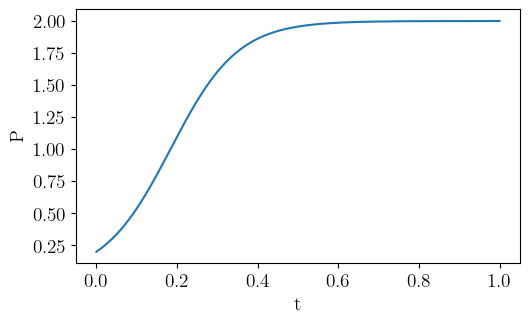

In [26]:
plt.plot(T,P)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/311/Logistic.png')
plt.savefig('../Figuras/311/Logistic.pdf')
plt.savefig('../Figuras/311/Logistic.svg')
plt.show()

In [4]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net_u(t, w, b):
    u = DNN(t, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W, b, r, k):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net_u(t, W, b)
    u_t = tape1.gradient(u, t) 
    f = u_t - r*u*(1-u/k[0])
    return f


#@tf.function()
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, r, k):
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,k])
        u_nn = net_u(t_u, W, b) 
        f_nn = net_f(t_f, W, b, r, k)
        loss_u = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss_k =  tf.reduce_mean(tf.square(k - tf.ones([1,1])*k_t))
        loss =  loss_u + loss_f
    grads = tape.gradient(loss, train_vars(W, b))
    grads_k = tape.gradient(loss, k)
    opt.apply_gradients(zip(grads, train_vars(W, b)))
    opt.apply_gradients(zip(grads_k, k))
    return loss, loss_u, loss_f, loss_k




# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 5 #Number of data
Nmax=  50000 #20000

layers = [1, 50, 50, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
k = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]


In [5]:
u_star = P.reshape([-1, 1])
X_star = T.reshape([-1, 1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = T[0]
uu1 = P[0]

# Additional data
idx = np.random.choice(P.shape[0], N_d, replace=False)
xxd = T[idx]
uud = P[idx]

X_u_train = np.concatenate(([xx1],xxd)).reshape([-1,1])
u_train = np.concatenate(([uu1],uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)


In [6]:
lr = 1e-4
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_u = []
loss_f = []
loss_k = []

while n <= Nmax:
    loss_, loss_u_, loss_f_, loss_k_ = train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, r, k)
    loss.append(loss_)
    loss_u.append(loss_u_)
    loss_f.append(loss_f_)
    loss_k.append(loss_k_)

    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u_}")
        print(f"Physicial loss is: {loss_f_}")
        print(f"k loss is: {loss_k_}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0
Total loss is: 2.750537395477295
Data loss is: 2.5928354263305664
Physicial loss is: 0.15770193934440613
k loss is: 1.0
Iteration is: 10
Total loss is: 2.7093615531921387
Data loss is: 2.7008354663848877
Physicial loss is: 0.008526118472218513
k loss is: 1.0013082027435303
Iteration is: 20
Total loss is: 2.7024078369140625
Data loss is: 2.6506855487823486
Physicial loss is: 0.05172238126397133
k loss is: 1.0021272897720337
Iteration is: 30
Total loss is: 2.7000820636749268
Data loss is: 2.6832950115203857
Physicial loss is: 0.016787098720669746
k loss is: 1.0033091306686401
Iteration is: 40
Total loss is: 2.6992602348327637
Data loss is: 2.664217233657837
Physicial loss is: 0.03504291921854019
k loss is: 1.0042545795440674
Iteration is: 50
Total loss is: 2.6988446712493896
Data loss is: 2.6754486560821533
Physicial loss is: 0.02339605614542961
k loss is: 1.0053142309188843
Iteration is: 60
Total loss is: 2.6986868381500244
Data loss is: 2.670304536819458
Physicial loss 

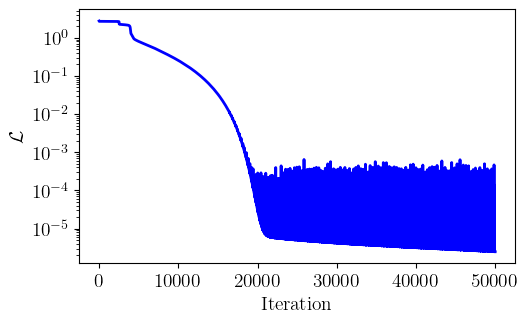

In [27]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_list_f = [loss_f[i].numpy() for i in range(0,Nmax)]
loss_list_u = [loss_u[i].numpy() for i in range(0,Nmax)]
loss_list_k = [loss_k[i].numpy() for i in range(0,Nmax)]

plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact') 
# plt.semilogy(it, np.asarray(loss_list_f), 'g-', linewidth = 2, label = 'Exact')  
# plt.semilogy(it, np.asarray(loss_list_k), 'r-', linewidth = 2, label = 'Exact')    
# plt.semilogy(it, np.asarray(loss_list_u), 'y-', linewidth = 2, label = 'Exact')       



plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/311/Loss.png')
plt.savefig('../Figuras/311/Loss.pdf')
plt.savefig('../Figuras/311/Loss.svg')
plt.show()

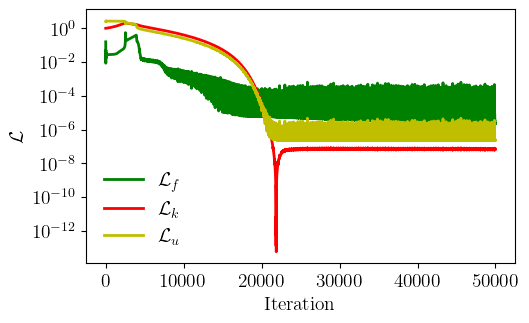

In [28]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_list_f = [loss_f[i].numpy() for i in range(0,Nmax)]
loss_list_u = [loss_u[i].numpy() for i in range(0,Nmax)]
loss_list_k = [loss_k[i].numpy() for i in range(0,Nmax)]

# plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact') 
plt.semilogy(it, np.asarray(loss_list_f), 'g-', linewidth = 2, label = '$\mathcal{L}_f$')  
plt.semilogy(it, np.asarray(loss_list_k), 'r-', linewidth = 2, label = '$\mathcal{L}_k$')    
plt.semilogy(it, np.asarray(loss_list_u), 'y-', linewidth = 2, label = '$\mathcal{L}_u$')       


plt.legend(fontsize=14, frameon=False,)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/311/Loss_split.png')
plt.savefig('../Figuras/311/Loss_split.pdf')
plt.savefig('../Figuras/311/Loss_split.svg')
plt.show()

In [35]:
k[0][0], (k[0][0]-2)/2*100

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.0002615], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01307726], dtype=float32)>)

In [24]:
def predict(X_star_tf, w, b):
    t_star = X_star_tf
    u_pred = net_u(t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_pred)


Error u: 2.386059e-04


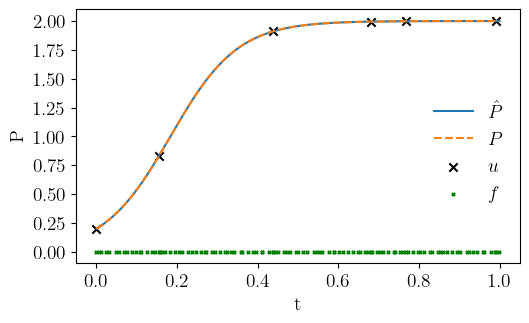

In [34]:
plt.plot(T, u_pred, label='$\hat{P}$')
plt.plot(T, P, linestyle='--', label='$P$')
plt.scatter(X_u_train, u_train, marker='x', color='black',label='$u$')
plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Figuras/311/Result.png')
plt.savefig('../Figuras/311/Result.pdf')
plt.savefig('../Figuras/311/Result.svg')
plt.show()